In [1]:
%run ../spark-default.py

In [2]:
import builtins as b
from datetime import datetime, timedelta, date
import sys, traceback
from delta.tables import DeltaTable

from scipy.cluster.hierarchy import linkage, dendrogram
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.ml.functions import vector_to_array
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml import Pipeline, PipelineModel

In [3]:
df = spark.table("stage.ciha_step3")

df.printSchema()

root
 |-- pk: string (nullable = true)
 |-- mes_cmpt: string (nullable = true)
 |-- espec: string (nullable = true)
 |-- cgc_hosp: string (nullable = true)
 |-- munic_res: string (nullable = true)
 |-- nasc: date (nullable = true)
 |-- sexo: string (nullable = true)
 |-- uti_mes_to: string (nullable = true)
 |-- uti_int_to: string (nullable = true)
 |-- proc_rea: string (nullable = true)
 |-- qt_proc: string (nullable = true)
 |-- dt_atend: date (nullable = true)
 |-- dt_atend_dow: integer (nullable = true)
 |-- dt_saida: date (nullable = true)
 |-- diag_princ: string (nullable = true)
 |-- diag_secun: string (nullable = true)
 |-- cobranca: string (nullable = true)
 |-- natureza: string (nullable = true)
 |-- gestao: string (nullable = true)
 |-- munic_mov: string (nullable = true)
 |-- cod_idade: string (nullable = true)
 |-- idade: string (nullable = true)
 |-- dias_perm: string (nullable = true)
 |-- morte: string (nullable = true)
 |-- nacional: string (nullable = true)
 |-- car_i

In [4]:
df.limit(5)

pk,mes_cmpt,espec,cgc_hosp,munic_res,nasc,sexo,uti_mes_to,uti_int_to,proc_rea,qt_proc,dt_atend,dt_atend_dow,dt_saida,diag_princ,diag_secun,cobranca,natureza,gestao,munic_mov,cod_idade,idade,dias_perm,morte,nacional,car_int,homonimo,cnes,fonte,cgc_consor,modalidade,input_file_name,arquivo_sigla_uf,ano_cmpt,feriado,feriados,feriados_prox,feriados_prox_dist,munic_res_nome_uf,munic_mov_nome_uf,munic_res_nome_municipio,munic_mov_nome_municipio,munic_res_sigla_uf,munic_mov_sigla_uf,munic_res_regiao,munic_mov_regiao,munic_res_populacao_residente,munic_mov_populacao_residente,munic_res_area_unidade_territorial,munic_mov_area_unidade_territorial,diag_princ_sub_categoria,diag_princ_sub_categoria_classificacao,diag_princ_restringido_sexo,diag_princ_causa_obito,diag_princ_sub_categoria_descricao,diag_princ_sub_categoria_descricao_abreviada,diag_princ_sub_categoria_referencia,diag_princ_sub_categoria_excluidos,diag_princ_categoria,diag_princ_categoria_classificacao,diag_princ_categoria_descricao,diag_princ_categoria_descricao_abreviada,diag_princ_categoria_referencia,diag_princ_capitulo_numero,diag_princ_capitulo_descricao,diag_princ_capitulo_descricao_abreviada,diag_secun_sub_categoria,diag_secun_sub_categoria_classificacao,diag_secun_restringido_sexo,diag_secun_causa_obito,diag_secun_sub_categoria_descricao,diag_secun_sub_categoria_descricao_abreviada,diag_secun_sub_categoria_referencia,diag_secun_sub_categoria_excluidos,diag_secun_categoria,diag_secun_categoria_classificacao,diag_secun_categoria_descricao,diag_secun_categoria_descricao_abreviada,diag_secun_categoria_referencia,diag_secun_capitulo_numero,diag_secun_capitulo_descricao,diag_secun_capitulo_descricao_abreviada,munic_res_idhm,munic_mov_idhm,proc_nome,proc_tp_complexidade,proc_tp_sexo,proc_qt_max_exec,proc_qt_dias_perm,proc_qt_pontos,proc_ds_procedimento,proc_no_grupo,proc_no_sub_grupo,proc_no_forma_organizacao
f8292abf-4df3-491...,06,null,60961422000155,355030,2019-04-08,3,0,000,0301010072,1,2024-06-20,5,2024-06-20,J039,null,18,null,M,355030,4,05,0,0,null,null,null,2089602,01,00000000000000,01,s3a://datalake/so...,SP,2024,false,null,"[{2024-05-30, Cor...",19,São Paulo,São Paulo,São Paulo,São Paulo,SP,SP,Sudeste,Sudeste,11253503,11253503,1521.101,1521.101,J039,null,null,null,Amigdalite aguda ...,J03.9 Amigdalite ...,null,null,J03,null,Amigdalite aguda,J03 Amigdalite ...,null,10,Capítulo X - Doen...,X. Doenças do a...,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.805,0.805,CONSULTA MEDICA E...,2,I,9999,9999,0000,CONSULTA CLÍNICA ...,Procedimentos clí...,Tratamentos clíni...,Tratamento de doe...
8ba519f8-620f-4bb...,11,null,44215341000150,350330,1973-02-15,3,0,000,0204030030,1,2024-11-11,2,2024-11-11,Z016,null,18,null,M,350330,4,51,0,0,null,null,null,2081253,01,00000000000000,01,s3a://datalake/so...,SP,2024,false,null,"[{2024-11-20, Dia...",4,São Paulo,São Paulo,Araras,Araras,SP,SP,Sudeste,Sudeste,118843,118843,644.831,644.831,Z016,null,null,null,Exame radiológico...,Z01.6 Exame radio...,null,null,Z01,null,Outros exames e i...,Z01 Outr exam i...,null,21,Capítulo XXI - Fa...,XXI. Contatos com...,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.781,0.781,MAMOGRAFIA,2,I,0002,9999,0000,EXAME RADIOLÓGICO...,Procedimentos com...,Diagnóstico em la...,Exames hematológi...
16f56e13-42bb-4c7...,04,null,16731630000176,310260,1946-03-07,3,0,000,0206010079,1,2024-04-28,1,2024-04-28,E889,null,18,null,M,310260,4,78,0,0,null,null,null,2775956,01,00000000000000,01,s3a://datalake/so...,MG,2024,false,null,"[{2024-05-01, Dia...",3,Minas Gerais,Minas Gerais,Andradas,Andradas,MG,MG,Sudeste,Sudeste,37270,37270,469.37,469.37,E889,null,null,null,Distúrbio metaból...,E88.9 Disturbio m...,null,null,E88,null,Outros distúrbios...,E88 Outr distur...,null,4,Capítulo IV - Doe...,IV. Doenças endó...,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.734,0.734,TOMOGRAFIA COMPUT...,3,I,0002,9999,0000,CONSISTE NO MÉ

In [5]:
df_prep = df.filter(
    col("feriado").isNotNull()
    & col("uti_int_to").cast("integer").isNotNull()
    & col("diag_princ_categoria").isNotNull()
).select(
    col("dt_atend"),
    date_format("dt_atend", "dd").cast("integer").alias("dt_atend_dia"),
    date_format("dt_atend", "MM").cast("integer").alias("dt_atend_mes"),
    date_format("dt_atend", "yyyy").cast("integer").alias("dt_atend_ano"),
    weekofyear("dt_atend").alias("dt_atend_woy"),
    col("nasc"),
    date_format("nasc", "dd").cast("integer").alias("dt_nasc_dia"),
    date_format("nasc", "MM").cast("integer").alias("dt_nasc_mes"),
    date_format("nasc", "yyyy").cast("integer").alias("dt_nasc_ano"),
    weekofyear("nasc").alias("dt_nasc_woy"),
    col("sexo"),
    col("uti_int_to").cast("integer").alias("uti_int_to"),
    col("qt_proc").cast("integer").alias("qt_proc"),
    col("dt_atend_dow"), # 1 -> Domingo, 7 -> Sabado
    col("dt_saida"),
    date_format("dt_saida", "dd").cast("integer").alias("dt_saida_dia"),
    date_format("dt_saida", "MM").cast("integer").alias("dt_saida_mes"),
    date_format("dt_saida", "yyyy").cast("integer").alias("dt_saida_ano"),
    weekofyear("dt_saida").alias("dt_saida_woy"),
    col("diag_princ"),
    # col("diag_secun"),
    col("idade").cast("integer").alias("idade"),
    col("dias_perm").cast("integer").alias("dias_perm"),
    when(col("feriado") == lit(True), lit(1)).otherwise(lit(0)).alias("feriado"),
    size(col("feriados")).alias("feriados_qtd"),
    size(col("feriados_prox")).alias("feriados_prox_qtd"),
    when(col("feriados_prox_dist").isNull(), lit(30)).otherwise(col("feriados_prox_dist")).alias("feriados_prox_dist"),
    col("munic_res_sigla_uf"),
    col("munic_mov_sigla_uf"),
    col("munic_res_nome_uf"),
    col("munic_mov_nome_uf"),
    col("munic_res_populacao_residente").cast("integer").alias("munic_res_populacao_residente"),
    col("munic_mov_populacao_residente").cast("integer").alias("munic_mov_populacao_residente"),
    col("munic_res_area_unidade_territorial").cast("integer").alias("munic_res_area_unidade_territorial"),
    col("munic_mov_area_unidade_territorial").cast("integer").alias("munic_mov_area_unidade_territorial"),
    col("munic_res_idhm").cast("integer").alias("munic_res_idhm"),
    col("munic_mov_idhm").cast("integer").alias("munic_mov_idhm"),
    col("diag_princ_categoria"),
    # col("diag_secun_categoria"),
    col("diag_princ_capitulo_numero"),
    # col("diag_secun_capitulo_numero"),
    col("proc_rea"),
    # col("proc_tp_complexidade"),
    # col("proc_tp_sexo"),
    # col("proc_qt_max_exec").cast("integer").alias("proc_qt_max_exec"),
    # col("proc_qt_dias_perm").cast("integer").alias("proc_qt_dias_perm"),
    # col("proc_qt_pontos").cast("integer").alias("proc_qt_pontos"),
    # col("proc_no_grupo"),
    # col("proc_no_sub_grupo"),
    col("morte").cast("integer").alias("morte")
)

categorical_cols = [
    "sexo",
    "dt_atend_dow",
    "diag_princ",
    # "diag_secun",
    "munic_res_sigla_uf",
    "munic_mov_sigla_uf",
    "munic_res_nome_uf",
    "munic_mov_nome_uf",
    "feriado",
    "diag_princ_categoria",
    # "diag_secun_categoria",
    "diag_princ_capitulo_numero",
    # "diag_secun_capitulo_numero",
    "proc_rea",
    # "proc_tp_complexidade",
    # "proc_tp_sexo",
    # "proc_no_grupo",
    # "proc_no_sub_grupo",
    "dt_atend_mes",
    "dt_nasc_mes",
    "dt_saida_mes"
]

numeric_cols = [
    "dt_atend_dia",
    "dt_atend_ano",
    "dt_atend_woy",
    "dt_nasc_dia",
    "dt_nasc_ano",
    "dt_nasc_woy",
    "dt_saida_dia",
    "dt_saida_ano",
    "dt_saida_woy",
    "uti_int_to",
    "qt_proc",
    "idade",
    "dias_perm",
    "feriados_qtd",
    "feriados_prox_qtd",
    "feriados_prox_dist",
    "munic_res_populacao_residente",
    "munic_mov_populacao_residente",
    "munic_res_area_unidade_territorial",
    "munic_mov_area_unidade_territorial",
    "munic_res_idhm",
    "munic_mov_idhm",
    # "proc_qt_max_exec",
    # "proc_qt_dias_perm",
    # "proc_qt_pontos"
]

df_treinamento = df_prep.filter("dt_atend between '2011-01-01' and '2023-12-31'").sample(withReplacement=False, fraction=0.5, seed=42)
df_teste = df_prep.filter("dt_atend between '2024-01-01' and '2024-12-31'").sample(withReplacement=False, fraction=0.5, seed=42)

target_col = 'morte'

In [6]:
# Analise nulos

prep_nulls = df_prep.select(count("*").alias("total"), *[count(when(col(c).isNull(), c)).alias(c) for c in df_prep.columns]).first().asDict()

prep_nulls_total = prep_nulls["total"]

df_prep_nulls = spark.createDataFrame(
    [{"col": k, "count": v, "percentual": b.round((v/prep_nulls_total) * 100, 2)} for k,v in prep_nulls.items()]
) #.orderBy(col("count").desc())

df_prep_nulls.show(200, truncate=False)

+----------------------------------+---------+----------+
|col                               |count    |percentual|
+----------------------------------+---------+----------+
|total                             |124513800|100.0     |
|dt_atend                          |0        |0.0       |
|dt_atend_dia                      |0        |0.0       |
|dt_atend_mes                      |0        |0.0       |
|dt_atend_ano                      |0        |0.0       |
|dt_atend_woy                      |0        |0.0       |
|nasc                              |0        |0.0       |
|dt_nasc_dia                       |0        |0.0       |
|dt_nasc_mes                       |0        |0.0       |
|dt_nasc_ano                       |0        |0.0       |
|dt_nasc_woy                       |0        |0.0       |
|sexo                              |0        |0.0       |
|uti_int_to                        |0        |0.0       |
|qt_proc                           |0        |0.0       |
|dt_atend_dow 

In [6]:
print(df_prep.count())
print(df_treinamento.count())
print(df_teste.count())

124513800
56131224
5006676


In [7]:
# Tabela com vies alto, tentativa com oversampling

# Na pratica deu bom, porem com uma razão de excesso de 23 (numero inexplicavel)

df_treinamento_m0 = df_treinamento.filter(df_treinamento.morte == 0)
df_treinamento_m1 = df_treinamento.filter(df_treinamento.morte == 1)

proporcao_mortes = df_treinamento_m0.count() / df_treinamento_m1.count()

df_treinamento_oversampled = df_treinamento_m1.sample(withReplacement=True, fraction=(proporcao_mortes))

df_treinamento_balanceado = df_treinamento_m0.union(df_treinamento_oversampled)

df_treinamento_balanceado.groupBy("morte").agg(count("*").alias("count"))

morte,count
0,55693150
1,55687741


In [8]:
# Tabela com vies alto, resolve com peso

# Aconteceu a mesma coisa do oversampling, foi tratado com uma correção do threshold a partir da probabilidade que o modelo entregou

df_treinamento_m0 = df_treinamento.filter(df_treinamento.morte == 0)
df_treinamento_m1 = df_treinamento.filter(df_treinamento.morte == 1)

total = df_treinamento_m0.count() + df_treinamento_m1.count()
peso_morte = total / (2 * (df_treinamento_m1.count()))
peso_nao_morte = total / (2 * df_treinamento_m0.count())

df_treinamento_pesado = df_treinamento.withColumn("peso", when(col("morte") == 1, peso_morte/23).otherwise(peso_nao_morte/(1/23)))

print("Total:", total)
print("Peso morte:", peso_morte)
print("Peso nao morte:", peso_nao_morte)

Total: 56131224
Peso morte: 64.0659158041792
Peso nao morte: 0.5039329253238504


In [43]:
label_indexer = StringIndexer(inputCol=target_col, outputCol="label")

indexers = [StringIndexer(inputCol=c, outputCol=c + "_index", handleInvalid="skip") for c in categorical_cols]
encoders = [OneHotEncoder(inputCol=c + "_index", outputCol=c + "_vec") for c in categorical_cols]

assembler_inputs = [c + "_vec" for c in categorical_cols] + numeric_cols
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

In [44]:
# rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100, weightCol="peso")
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100)

In [45]:
stages = [label_indexer] + indexers + encoders + [assembler, rf]
pipeline = Pipeline(stages=stages)

modelo_treinado = pipeline.fit(df_treinamento_balanceado)

In [46]:
modelo_treinado.write().overwrite().save("s3a://datalake/models/classificacao_ciha_full_sample50/")

In [9]:
modelo_treinado = PipelineModel.load("s3a://datalake/models/classificacao_ciha_full_sample50/")

In [10]:
df_pred = modelo_treinado.transform(df_teste)

In [13]:
from pyspark.ml.linalg import DenseVector
from pyspark.sql.functions import udf
from pyspark.sql.types import StructType, StructField, DoubleType
from pyspark.ml.linalg import VectorUDT
import numpy

def adjust_vector(vector):
    to_adjust = 0.0835
    values = list(vector)  # Converte DenseVector em lista
    values[0] += to_adjust       # Soma em um valor
    values[1] -= to_adjust       # Subtrai no outro
    return DenseVector(values)

adjust_vector_udf = udf(adjust_vector, VectorUDT())

df_pred_corrigido = df_pred.select(
    col("dt_atend"),
    col("prediction").alias("old_prediction"),
    col("probability").alias("old_probability"),
    adjust_vector_udf("probability").alias("probability"),
    when(
        vector_to_array(adjust_vector_udf("probability"))[1] > 0.50, # Base com um vies muito forte, modelo treinado com peso nas classes e tambem foi necessário aplicar um threshold diferente
        lit(1.0)
    ).otherwise(0.0).alias("prediction"),
    col("morte").cast("integer").alias("morte")
)

In [12]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

df_pred_ = df_pred_corrigido

avaliador1 = MulticlassClassificationEvaluator(
    labelCol="morte",           # nome da coluna com a classe real
    predictionCol="prediction"  # nome da coluna com a predição
)

acuracia = avaliador1.setMetricName("accuracy").evaluate(df_pred_)
precisao = avaliador1.setMetricName("weightedPrecision").evaluate(df_pred_)
revocacao = avaliador1.setMetricName("weightedRecall").evaluate(df_pred_)
f1 = avaliador1.setMetricName("f1").evaluate(df_pred_)

avaliador2 = BinaryClassificationEvaluator(
    labelCol="morte",                 # nome da coluna com a classe real
    rawPredictionCol="probability",   # nome da coluna com a probabilidade
    metricName="areaUnderROC"
)

auc = avaliador2.evaluate(df_pred_)

print(f"Acurácia: {acuracia}")
print(f"Precisão Ponderada: {precisao}")
print(f"Revocação Ponderada: {revocacao}")
print(f"F1 Score: {f1}")
print(f"AUC: {auc}")

Acurácia: 0.9855800581776336
Precisão Ponderada: 0.9859746252953115
Revocação Ponderada: 0.9855800581776336
F1 Score: 0.9857773022541261
AUC: 0.1343469920009731


In [98]:
ix = 0.5
while ix <= 0.65:
    df_trial = df_pred.select(
        col("dt_atend"),
        # col("prediction"),
        col("probability"),
        when(
            vector_to_array("probability")[1] > ix, # Base com um vies muito forte, modelo treinado com peso nas classes e tambem foi necessário aplicar um threshold de 55.5%
            lit(1.0)
        ).otherwise(0.0).alias("prediction"),
        col("morte")
    )
    avaliador_ix = MulticlassClassificationEvaluator(
        labelCol="morte",           # nome da coluna com a classe real
        predictionCol="prediction"  # nome da coluna com a predição
    )
    f1_ix = avaliador_ix.setMetricName("f1").evaluate(df_trial)
    print("IX:", ix, "f1_IX:", f1_ix)
    ix += .005

IX: 0.5 f1_IX: 0.24315207183848733
IX: 0.505 f1_IX: 0.30238988313271625
IX: 0.51 f1_IX: 0.3664456347186679
IX: 0.515 f1_IX: 0.4625156019559258
IX: 0.52 f1_IX: 0.5498120968069299
IX: 0.525 f1_IX: 0.6235011255062903
IX: 0.53 f1_IX: 0.6858239519842027
IX: 0.535 f1_IX: 0.737469440292028
IX: 0.54 f1_IX: 0.7902010983502161
IX: 0.545 f1_IX: 0.841897007769445
IX: 0.55 f1_IX: 0.8842373264448775
IX: 0.555 f1_IX: 0.9156414681311135
IX: 0.56 f1_IX: 0.943023516718199
IX: 0.5650000000000001 f1_IX: 0.9655490355720943
IX: 0.5700000000000001 f1_IX: 0.9744357529840894
IX: 0.5750000000000001 f1_IX: 0.9800595584845125
IX: 0.5800000000000001 f1_IX: 0.9840435210143159
IX: 0.5850000000000001 f1_IX: 0.986487104760491
IX: 0.5900000000000001 f1_IX: 0.9881436395190074
IX: 0.5950000000000001 f1_IX: 0.9891298691038387
IX: 0.6000000000000001 f1_IX: 0.9894297737488387
IX: 0.6050000000000001 f1_IX: 0.9894949074456086
IX: 0.6100000000000001 f1_IX: 0.9894954069042514
IX: 0.6150000000000001 f1_IX: 0.9894954069042514
IX:

In [50]:
df_grafico = df_treinamento.select(
    col("dt_atend"),
    col("morte"),
    lit("treinamento").alias("dataset")
).union(
    df_pred_corrigido.select(
        col("dt_atend"),
        col("prediction").cast("integer").alias("morte"),
        lit("predict").alias("dataset")
    )
).union(
    df_teste.select(
        col("dt_atend"),
        col("morte"),
        lit("teste").alias("dataset")
    )
).withColumn("dt_atend_mes", date_format("dt_atend", "yyyy-MM")) \
 .groupBy(
    col("dt_atend_mes"),
    col("dataset")
 ).agg(
     sum("morte").alias("morte")
 )#.cache()

# df_grafico

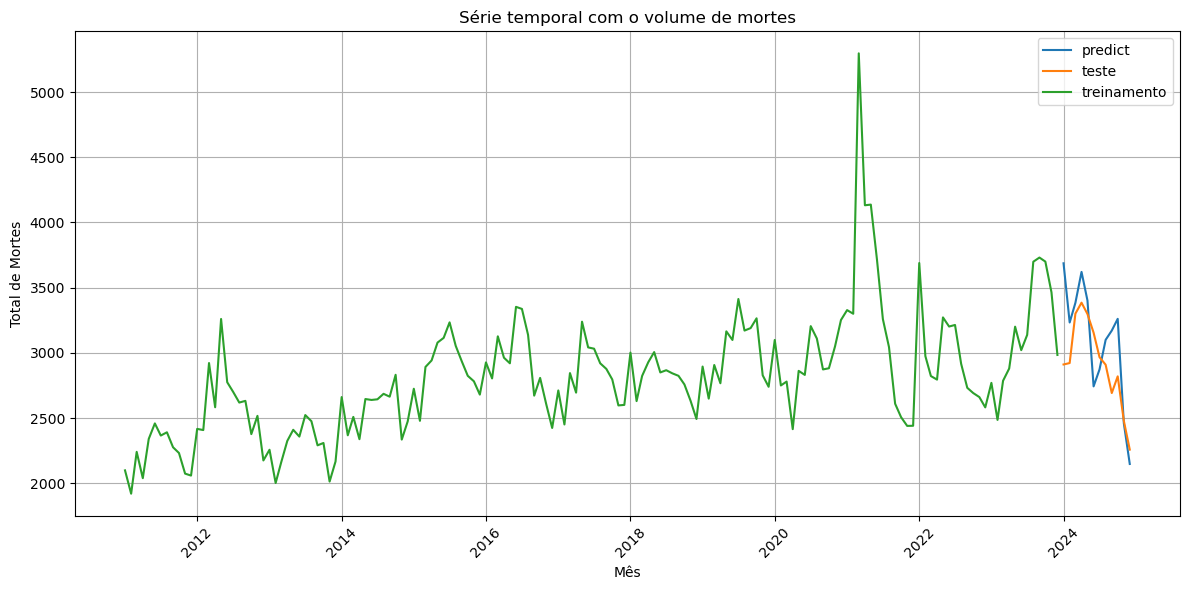

In [51]:
df_grafico_pd = df_grafico.toPandas()

df_grafico_pd['dt_atend_mes'] = pd.to_datetime(df_grafico_pd['dt_atend_mes'], format='%Y-%m')
df_grafico_pd = df_grafico_pd.sort_values('dt_atend_mes')
    
plt.figure(figsize=(12, 6))

for nome_dataset, grupo in df_grafico_pd.groupby("dataset"):
    if nome_dataset == "predict":
        plt.plot(grupo["dt_atend_mes"], grupo["morte"], label=nome_dataset)
    else:
        plt.plot(grupo["dt_atend_mes"], grupo["morte"], label=nome_dataset)

plt.xlabel("Mês")
plt.ylabel("Total de Mortes")
plt.title("Série temporal com o volume de mortes")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

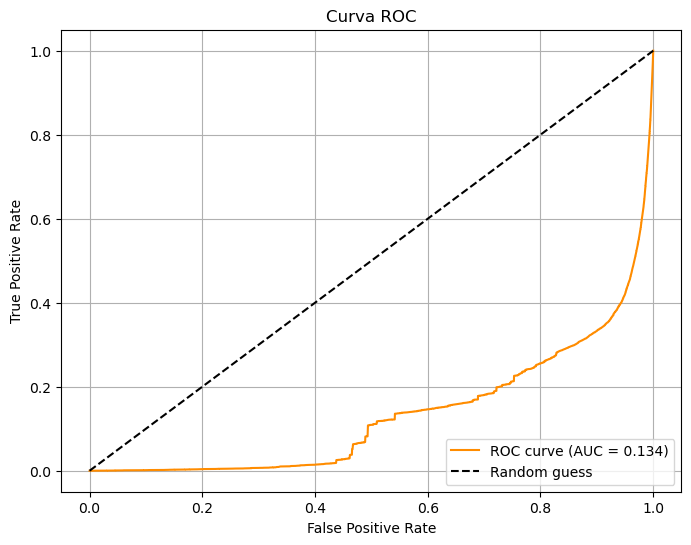

In [18]:
from sklearn.metrics import roc_curve, roc_auc_score

df_plot = df_pred_corrigido.select("morte", "probability")
df_pd = df_plot.toPandas()

df_pd["prob_pos"] = df_pd["probability"].apply(lambda v: float(v[1]))

fpr, tpr, thresholds = roc_curve(df_pd["morte"], df_pd["prob_pos"])
auc = roc_auc_score(df_pd["morte"], df_pd["prob_pos"])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.3f})", color="darkorange")
plt.plot([0, 1], [0, 1], "k--", label="Random guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


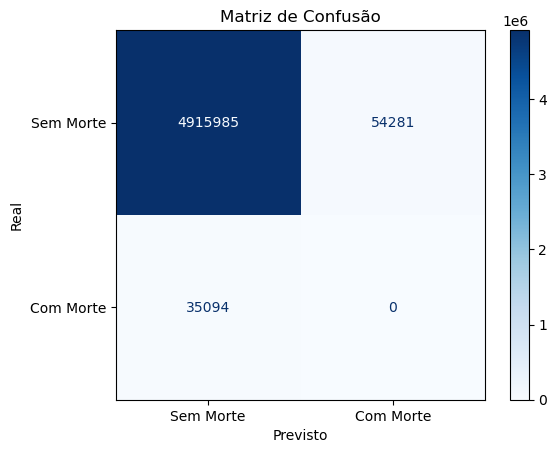

In [104]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

df_pd = df_pred_corrigido.select("morte", "prediction").toPandas()

labels = [0, 1]
cm = confusion_matrix(df_pd["morte"], df_pd["prediction"], labels=labels)

display_labels = ["Sem Morte", "Com Morte"]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d')
# ax.ticklabel_format(style='plain', axis='both')
plt.title("Matriz de Confusão")
plt.grid(False)
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

In [16]:
spark.stop()